# RESOLVE Data Tutorial
This jupyter notebook illustrates use of the public RESOLVE (REsolved Spectroscopy Of a Local VolumE) survey database, including HI upper limit and confusion information. As of this writing, the HI mass census is fully available (Stark et al. 2016), but HI profile metrics are still being analyzed. The optical spectroscopic census is ~70% complete and is still being reduced and analyzed.<br/>

Note that the RESOLVE catalog and all calculations below assume H_0 = 70 km/s/Mpc, implying a combined volume for RESOLVE-A and RESOLVE-B of 52,135 cubic Mpc.<br/>

The RESOLVE website at http://resolve.astro.unc.edu/ provides further information, data, and links to papers as well as details on the ECO (Environmental COntext) catalog. ECO is a nearly ten times larger data set surrounding RESOLVE with comparable photometric and environmental data, but it has no new radio or optical spectroscopy beyond SDSS/ALFALFA. A follow-up tutorial demonstrating the use of ECO to correct for cosmic variance in RESOLVE (in the spirit of Eckert et al. 2016) will be provided soon, along with a forthcoming analysis of the bivariate HI mass function comparing RESOLVE and the Simba simulation (Kannappan, Dave, Eckert, et al., in prep.) -- check for updates at the RESOLVE website!

Author: Sheila Kannappan<br/>
Created: August 2019

### Preliminaries

In [1]:
# standard imports and naming conventions; uncomment as needed
import numpy as np              # basic numerical analysis
import matplotlib.pyplot as plt # plotting
import matplotlib as mp

%matplotlib inline

The RESOLVE DR3 csv file is provided in the same github repo as this jupyter notebook, and the README provides instructions to retrieve it. If you wish to obtain a different data release, visit the RESOLVE "searchable database" page [here](http://resolve.astro.unc.edu/pages/database.php), which includes all data releases as well as sample sql queries. The simplest possible query, `select *`, will retrieve an entire database (before clicking submit, be sure to switch the output choice from "browse the results of the query" to "download the results of the query (CSV)"). The [same page](http://resolve.astro.unc.edu/pages/database.php) provides a glossary for each data release. Open the glossary matching the data release you are using in a separate tab.

In [2]:
# read in RESOLVE DR3 csv file, assuming it is in the same directory as this jupyter notebook
data = np.genfromtxt("RESOLVE_DR3.csv", delimiter=",", dtype=None, names=True)
# alternate version below if you get an error message regarding encoding
#data = np.genfromtxt("RESOLVE_DR3.csv", delimiter=",", dtype=None, names=True, encoding=None)

If you want to look at the column names, type `data.dtype.names`, but they should match the glossary [here](http://resolve.astro.unc.edu/pages/database.php) except for possible capitalization differences.

### Sample Selection

The RESOLVE database includes galaxies that are not officially part of the survey. They may either have redshifts in the buffer range used for group-finding or have magnitudes fainter than the survey luminosity floor. In some cases data for these galaxies may be useful, but please do not expect all of it to be carefully vetted. We recommend working with one of the following sample definitions to isolate complete, high-quality data sets:<br/><br/>
1) the original luminosity- and volume-limited sample: brighter than -17.33 (A-semester) or -17.0 (B-semester) with Grpcz between 4500-7000 km/s<br/>
2) the observational sample (for new 21cm and optical spectroscopy): same as #1, but adding in galaxies with known or estimated log(M\*+1.4MHI)> 9.2 (A-semester) or 9.0 (B-semester) <br/>
3) the baryonic mass complete sample: Grpcz between 4500-7000 km/s and log Mbary> 9.2 (A-semester) or 9.0 (B-semester), where Mbary = (M\*+1.4MHI)<br/>
4) the stellar mass complete sample: Grpcz between 4500-7000 km/s and log M\*> 8.9 (A-semester) or 8.7 (B-semester)<br/><br/>
**NOTE 1:** Eckert et al. (2016, 2017) adopted higher baryonic mass completeness limits: log Mbary> 9.4 (for ECO containing RESOLVE-A) and log Mbary> 9.1 (for RESOLVE-B); note however that RESOLVE-A is more complete than ECO as a whole <br/>
NOTE 2: To simplify analysis, Stark et al. (2016) adopted a common floor for both RESOLVE-A and RESOLVE-B: log M\* > 8.9 and log Mbary > 9.3<br/>

### We will first select the original luminosity-complete data set (\#1 above).


In [3]:
grpcz = data['grpcz']
invol = (grpcz >= 4500) & (grpcz < 7000)
fl_insample = data['fl_insample'] # flag for original luminosity limits as in #1 above
inorigsample = invol & fl_insample
print("in sample %i" % np.sum(inorigsample))
print("in catalog %i" % len(inorigsample))

in sample 1443
in catalog 2286


### Before looking at the HI data, let's examine the stellar mass, color, and environment properties of this sample.

In [4]:
logmstar = data['logmstar']
urcolor = data['modelu_r']
urcolorcorr = data['modelu_rcorr'] # internal extinction-corrected, useful for sequence separation
logmhalo = data['logmh'] # use the groups/halo masses defined for the luminosity-limited sample
fc = data['fc'] # central/satellite flag (1/0)
cent = (fc == 1)
sat = (fc == 0)

In [5]:
#optionally test that these quantities are valid for all original sample galaxies
#print(np.sum(logmstar[np.where(inorigsample)] > 0))
#print(np.sum(urcolorcorr[np.where(inorigsample)] > 0))
#print(np.sum(logmhalo[np.where(inorigsample)] > 0))

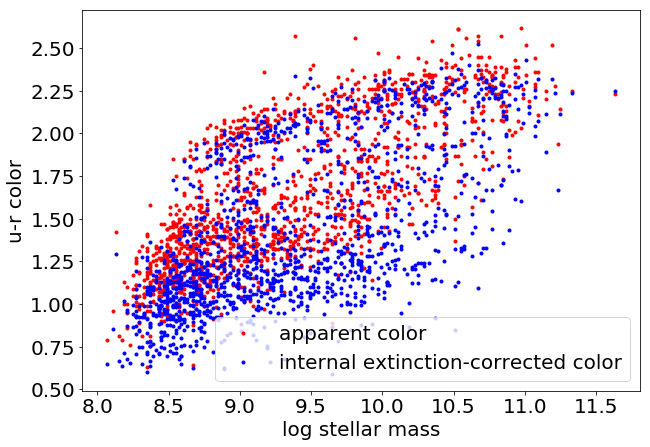

In [6]:
font = {'size' : 20}
mp.rc('font', **font)
fig1 = plt.figure(1,figsize=(10,7))
plt.clf()
plt.plot(logmstar[np.where(inorigsample)],urcolor[np.where(inorigsample)],'r.', label="apparent color")
plt.plot(logmstar[np.where(inorigsample)],urcolorcorr[np.where(inorigsample)],'b.', label="internal extinction-corrected color")
plt.xlabel("log stellar mass")
plt.ylabel("u-r color")
plt.legend(loc="best")

centrals: 1030
satellites: 413


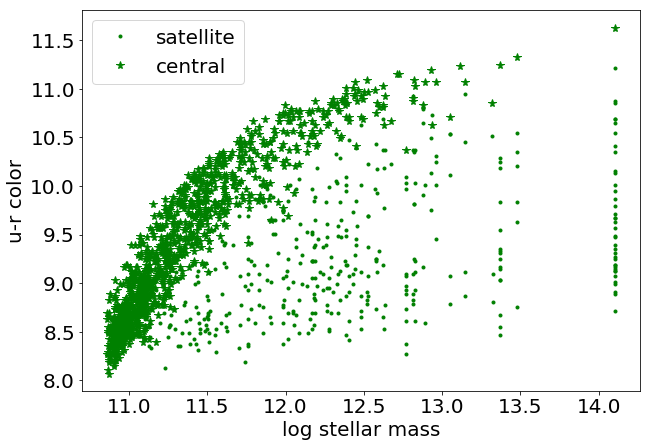

In [7]:
fig2 = plt.figure(2,figsize=(10,7))
plt.clf()
plt.plot(logmhalo[np.where(inorigsample & sat)],logmstar[np.where(inorigsample & sat)],'g.', label="satellite")
plt.plot(logmhalo[np.where(inorigsample & cent)],logmstar[np.where(inorigsample & cent)],'g*', markersize=8, label="central")
plt.xlabel("log stellar mass")
plt.ylabel("u-r color")
plt.legend(loc="best")
print("centrals: %i" % np.sum(cent[np.where(inorigsample)]))
print("satellites: %i" % np.sum(sat[np.where(inorigsample)]))

This figure serves as a useful reminder that contrary to our intuition, *most galaxies are centrals*. This follows from the steeply rising mass function of parent dark matter halos: at any halo mass, there are many more parent halos than subhalos of higher-mass halos, even though those subhalos obviously outnumber their parent halos.

### Now let's tackle the HI data. Skip straight to cell 12 if you just want "the answer" -- the next four cells show what's under the hood.

In [8]:
H_0=70. #km/s/Mpc
DinMpc = grpcz/H_0
f21 = data['f21']
logmhi = np.log10(f21 * 2.36e5 * (DinMpc)**2)

# first let's see where we started (with ALFALFA)
hitelescope = data['hitelescope']
limflagmhi = data['limflagmhi']
ef21 = data['e_f21']
ef21[np.where(ef21 == 0)] = np.nan # unclear why there is a stray zero in ef21, should be NaN
notmissing = np.where(~np.isnan(ef21))
snr21 = np.zeros(len(ef21))
snr21[notmissing] = f21[notmissing]/ef21[notmissing]
sel1 = np.where(inorigsample & (hitelescope == "ALFALFA") & (snr21 >= 5) & (limflagmhi == 0)) # note 5 not 6.5
sel2 = np.where(inorigsample & (hitelescope == "ALFALFA") & (snr21 < 5) & (snr21 > 0) & (limflagmhi == 0))
sel3 = np.where(inorigsample & (hitelescope == "ALFALFA") & (limflagmhi == 1))
hitostars1 = (10**logmhi[sel1]) / (10**logmstar[sel1])
hitostars2 = (10**logmhi[sel2]) / (10**logmstar[sel2])
hitostars3 = (10**logmhi[sel3]) / (10**logmstar[sel3])
print(len(sel1[0]))
print(len(sel2[0]))
print(len(sel3[0]))

665
5
89


Text(0,0.5,u'HI-to-stellar mass ratio')

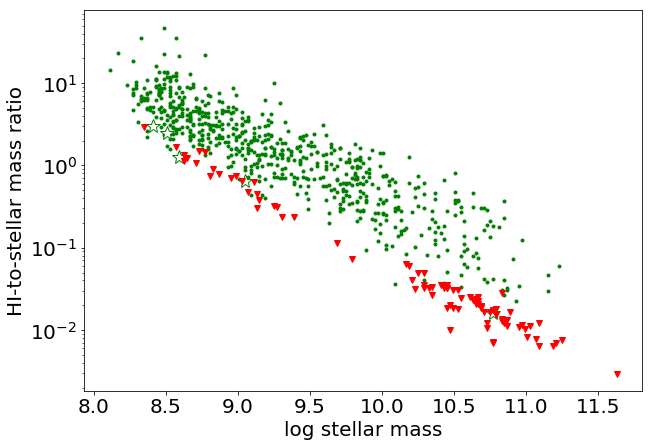

In [9]:
fig2 = plt.figure(2,figsize=(10,7))
plt.clf()
plt.plot(logmstar[sel1],hitostars1,'g.', label="ALFALFA high SNR")
plt.plot(logmstar[sel2],hitostars2,'g*', markersize=15, markerfacecolor="white", label="ALFALFA low SNR (cat?)")
plt.plot(logmstar[sel3],hitostars3,'rv', label="ALFALFA upper lim (not cat)")
plt.yscale('log')
plt.xlabel("log stellar mass")
plt.ylabel("HI-to-stellar mass ratio")

441
238


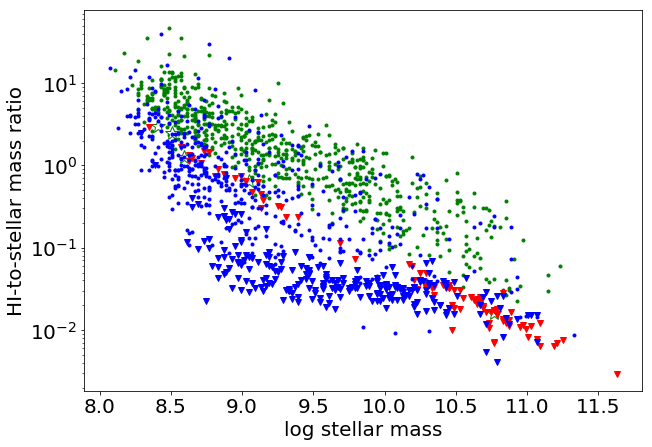

In [10]:
# add new data (detections and upper limits separately)
sel4 = np.where(inorigsample & (hitelescope != "ALFALFA") & (limflagmhi != 1) & (~np.isnan(ef21))) # again, not missing
hitostars4 = (10**logmhi[sel4]) / (10**logmstar[sel4])
sel5 = np.where(inorigsample & (hitelescope != "ALFALFA") & (limflagmhi == 1))
hitostars5 = (10**logmhi[sel5]) / (10**logmstar[sel5])

# repeat plot
fig3 = plt.figure(3,figsize=(10,7))
plt.clf()
plt.plot(logmstar[sel1],hitostars1,'g.', label="ALFALFA high SNR")
plt.plot(logmstar[sel2],hitostars2,'g*', markersize=15, markerfacecolor="white", label="ALFALFA low SNR (cat?)")
plt.plot(logmstar[sel3],hitostars3,'rv', label="ALFALFA upper lim (not cat)")
plt.yscale('log')
plt.xlabel("log stellar mass")
plt.ylabel("HI-to-stellar mass ratio")
# add new data to plot
plt.plot(logmstar[sel4],hitostars4,'b.', label="new high SNR")
plt.plot(logmstar[sel5],hitostars5,'bv', label="new upper lim")

print(len(sel4[0]))
print(len(sel5[0]))

66
122
188


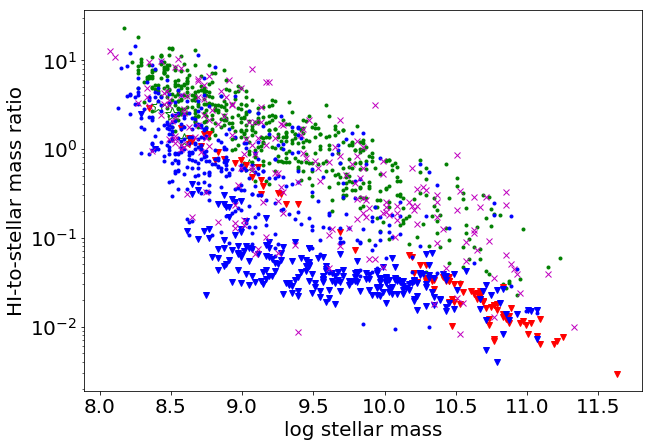

In [11]:
# replace confused detections with successfully deconfused data
confused = data['confused']
f21corr = data['f21corr'] # deconfused flux
ef21corr_rand = data['ef21corr_rand'] # random error on deconfused flux
ef21corr_sys = data['ef21corr_sys'] # systematic error on deconfused flux
f21corr[np.where(f21corr == 0)] = np.nan # treat zero in f21corr as NaN
notempty = np.where(~np.isnan(f21corr))
deconfokay = np.zeros(len(f21corr),dtype=bool)
deconfokay[notempty] = (ef21corr_sys[notempty]/f21corr[notempty]) < 0.25
goodconf = (confused == 1) & deconfokay # successfully deconfused
badconf = (confused == 1) & ~deconfokay # unsuccessfully deconfused
logmhicorr = np.log10(f21corr * 2.36e5 * (DinMpc)**2) # deconfused HI mass

notconf = (confused != 1)
sel1b = np.where(inorigsample & (hitelescope == "ALFALFA") & (snr21 >= 5) & (limflagmhi == 0) & notconf) # note 5 not 6.5
sel2b = np.where(inorigsample & (hitelescope == "ALFALFA") & (snr21 < 5) & (snr21 > 0) & (limflagmhi == 0) & notconf)
sel3b = np.where(inorigsample & (hitelescope == "ALFALFA") & (limflagmhi == 1) & notconf) # notconf is unnecessary here
sel4b = np.where(inorigsample & (hitelescope != "ALFALFA") & (limflagmhi != 1) & (~np.isnan(ef21)) & notconf) # again, not missing
sel5b = np.where(inorigsample & (hitelescope != "ALFALFA") & (limflagmhi == 1) & notconf) # notconf is unnecessary here
hitostars1b = (10**logmhi[sel1b]) / (10**logmstar[sel1b])
hitostars2b = (10**logmhi[sel2b]) / (10**logmstar[sel2b])
hitostars3b = (10**logmhi[sel3b]) / (10**logmstar[sel3b])
hitostars4b = (10**logmhi[sel4b]) / (10**logmstar[sel4b])
hitostars5b = (10**logmhi[sel5b]) / (10**logmstar[sel5b])

sel6 = np.where(inorigsample & goodconf)
hitostars6 = (10**logmhicorr[sel6]) / (10**logmstar[sel6])

# will need photometric gas fractions for unsuccessfully deconfused galaxies
modeluj = data['modelu_j']
b_a=data['b_a']
modcolor = 1.140*modeluj + 0.594*(b_a) # from Eckert et al (2015) -- 1D fit with survival analysis on Mgas-to-M* limits
photloggovers = 3.659 -0.981*modcolor # from Eckert et al (2015) volume-limited calibration, ~0.3 dex scatter
logmhiphot = np.log10((10**photloggovers/1.4) * 10**logmstar) # take out 1.4 for Helium --> just HI

sel7 = np.where(inorigsample & badconf)
hitostars7 = (10**logmhiphot[sel7]) / (10**logmstar[sel7])

# repeat plot replacing confused data with deconfused data or photometric estimates
fig4 = plt.figure(4,figsize=(10,7))
plt.clf()
plt.plot(logmstar[sel1b],hitostars1b,'g.', label="ALFALFA high SNR")
plt.plot(logmstar[sel2b],hitostars2b,'g*', markersize=15, markerfacecolor="white", label="ALFALFA low SNR (cat?)")
plt.plot(logmstar[sel3b],hitostars3b,'rv', label="ALFALFA upper lim (not cat)")
plt.plot(logmstar[sel4b],hitostars4b,'b.', label="new high SNR")
plt.plot(logmstar[sel5b],hitostars5b,'bv', label="new upper lim")
plt.plot(logmstar[sel6],hitostars6,'mx', markersize=6, label="successfully deconfused")
plt.plot(logmstar[sel7],hitostars7,'mx', markersize=6, label="badly confused, phot-HI")
plt.yscale('log')
plt.xlabel("log stellar mass")
plt.ylabel("HI-to-stellar mass ratio")

print(len(sel6[0]))
print(len(sel7[0]))
print(np.sum((confused == 1) & inorigsample))

Text(0,0.5,u'HI-to-stellar mass ratio')

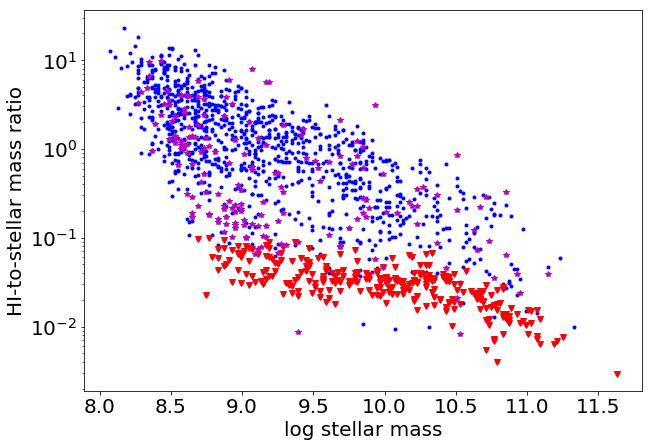

In [12]:
bestlogmhi = logmhi.copy()
bestlogmhi[np.where(goodconf)] = logmhicorr[np.where(goodconf)]
bestlogmhi[np.where(badconf)] = logmhiphot[np.where(badconf)]
weaklimit = np.zeros(len(logmstar),dtype=bool)
weaklimit[np.where(limflagmhi == 1)] =  (10**logmhi[np.where(limflagmhi == 1)])/(10**logmstar[np.where(limflagmhi == 1)]) > 0.1
bestlogmhi[np.where(weaklimit)] = logmhiphot[np.where(weaklimit)]
missing = np.isnan(f21)
bestlogmhi[np.where(missing)] = logmhiphot[np.where(missing)]
stronglimit = (limflagmhi == 1) & ~weaklimit
selall = np.where(inorigsample)
sellim = np.where(inorigsample & stronglimit)
fakedata = weaklimit | missing | badconf
selfake = np.where(inorigsample & fakedata)

besthitostars = (10**bestlogmhi) / (10**logmstar)

fig5 = plt.figure(5,figsize=(10,7))
plt.clf()
plt.plot(logmstar[selall],besthitostars[selall],'b.', label="good data")
plt.plot(logmstar[sellim],besthitostars[sellim],'rv', label="upper limit")
plt.plot(logmstar[selfake],besthitostars[selfake],'m*', label="phot-HI")
plt.yscale('log')
plt.xlabel("log stellar mass")
plt.ylabel("HI-to-stellar mass ratio")

Text(0,0.5,u'HI-to-stellar mass ratio')

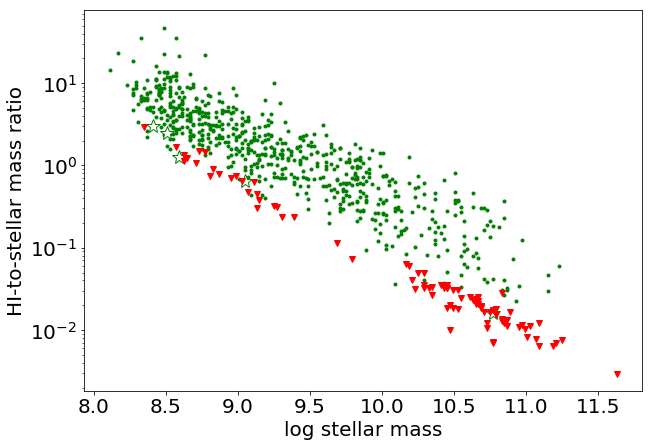

In [13]:
# compare to the original
fig2 = plt.figure(2,figsize=(10,7))
plt.clf()
plt.plot(logmstar[sel1],hitostars1,'g.', label="ALFALFA high SNR")
plt.plot(logmstar[sel2],hitostars2,'g*', markersize=15, markerfacecolor="white", label="ALFALFA low SNR (cat?)")
plt.plot(logmstar[sel3],hitostars3,'rv', label="ALFALFA upper lim (not cat)")
plt.yscale('log')
plt.xlabel("log stellar mass")
plt.ylabel("HI-to-stellar mass ratio")

### Now we can define a baryonic mass for every galaxy (treating strong upper limits as measurements since they represent tiny perturbations on the mass in stars). As an r-band selected survey, RESOLVE is most naturally baryonic mass limited.

Text(0,0.5,u'atomic gas-to-stellar mass ratio')

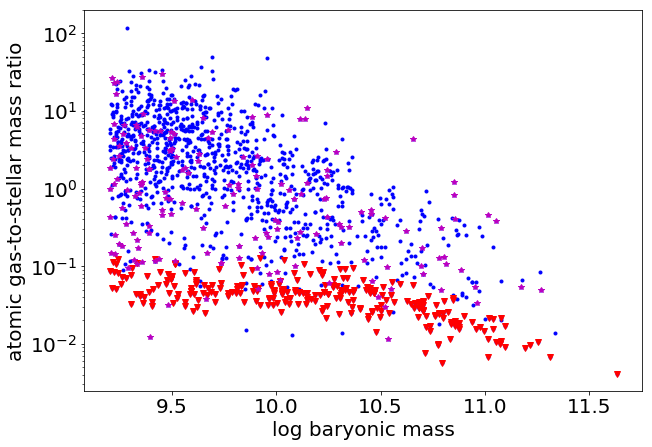

In [16]:
logmbary = np.log10(10**logmstar + 1.4*(10**bestlogmhi)) # bringing back the Helium correction
inbarylimsample = logmbary > 9.2
selall = np.where(inbarylimsample)
sellim = np.where(inbarylimsample & stronglimit)
selfake = np.where(inbarylimsample & fakedata)

fig6 = plt.figure(6,figsize=(10,7))
plt.clf()
plt.plot(logmbary[selall],1.4*besthitostars[selall],'b.', label="good data")
plt.plot(logmbary[sellim],1.4*besthitostars[sellim],'rv', label="upper limit")
plt.plot(logmbary[selfake],1.4*besthitostars[selfake],'m*', label="phot-HI")
plt.yscale('log')
plt.xlabel("log baryonic mass")
plt.ylabel("atomic gas-to-stellar mass ratio")

# Need to check on 10% strong limit criterion for HI or 1.4HI